In [1]:
import splines
import torch
import glob
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchsummary import summary
import scipy
from tqdm.notebook import tqdm
import plotly.graph_objects as go
import plotly.express as px
import encoded
from torch.utils.data import IterableDataset, DataLoader
# !nvidia-smi

In [2]:
device="cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
back_dict=splines.mat_to_dict()
spline_prims=splines.spline_dict(back_dict)
images=splines.dict_images()

In [4]:
dataset=encoded.OmniglotData(spline_prims)
data_loader=DataLoader(dataset,batch_size=1,shuffle=False) # Using batchsize 1 to get single primitive at a time.
# Create instances of models
enc=encoded.encoder(latent_dim=2).to(device)
dec=encoded.decoder(latent_dim=2).to(device)
# Loading weights
enc.load_state_dict(torch.load('./weights/2-d/encoder.pth',map_location=torch.device('cpu')))
dec.load_state_dict(torch.load('./weights/2-d/decoder.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

In [5]:
x_2d=[]
y_2d=[]
for i,data in tqdm(enumerate(data_loader)):
    data=data.to(device)
    mu,var=enc(data)
    lat_var=encoded.gen_latent(mu,var).squeeze().detach().cpu().numpy()
    x_2d.append(lat_var[0].item());y_2d.append(lat_var[1].item())

In [6]:
from sklearn.cluster import KMeans
import time
start=time.time()
X=np.concatenate((np.reshape(x_2d,(-1,1)),np.reshape(y_2d,(-1,1))),axis=1)
kmeans = KMeans(300, random_state=0)
labels = kmeans.fit(X).predict(X)
print("%d"%(time.time()-start))

124


In [7]:
print(len(labels))
print('max: ',np.max(labels,0))

48762
max:  299


In [8]:
count=0
data=images
# images[lang][character][0]['image'][instance][0] -> (105,105) numpy ndarray
for lang in data:
    for char in data[lang]:
        for inst in char:
            vector=np.zeros((300))
            for prim in inst[0]:
                # yield torch.tensor(prim.reshape(-1)).float()
                # yield torch.tensor(self.normalize(prim).reshape(-1)).float()
                idx=labels[count]
                vector[idx]+=1.
                count+=1
            

KeyError: 0

In [13]:
# Let us now prepare the dataloader for the next model, for performing 
# supervised learning using the one-hot encoded vectors of a particular character.

class OneHotDataset(IterableDataset):
    """
    Iterable form dataset for providing one-hot encoded vectors for each character.
    
    Args:
        data (dict): Just pass the spline_prims variable.
        images (dict): Just pass the image dict.
        labels (iterable type object): Labels for clustered data.
        
    Returns:
        (Tensor) : One-hot encoded vector of length 300. (image,target)
    """
    def __init__(self,data,images,labels,oh_len):
        self.data=data
        self.images=images
        self.labels=labels
        self.oh_len=oh_len
    
    def stream(self):
        # spline_prims[lang][char][inst][0][primitive]
        # images[lang][char][0]['image'][inst][0] -> (105,105) numpy ndarray
        count=0
        for lang in self.data:
            for i,char in enumerate(self.data[lang]):
                for j,inst in enumerate(char):
                    vector=np.zeros((self.oh_len))
                    for prim in inst[0]:
                        # yield torch.tensor(prim.reshape(-1)).float()
                        # yield torch.tensor(self.normalize(prim).reshape(-1)).float()
                        idx=self.labels[count]
                        vector[idx]+=1.
                        count+=1
                    # yield [image,vector]
                    img=self.images[lang][i][0]['image'][j][0]
                    yield [torch.tensor(img).unsqueeze(0).float(),torch.tensor(vector).float()]
                    
    def __len__(self):
        return int(19280) # Literally meaningless, hardcoded
    
    def __iter__(self):
        return self.stream()
        

In [14]:
def which_cluster(vector):
    """
    Dummy function to just give the indices of the clusters.
    
    Arg:
        vector: You know what it is.
    """
    vector=vector.reshape(-1)
    which=[]
    idx=0
    for _ in vector:
        if vector[idx]==1:
            which.append(idx)
        if vector[idx]>1:
            which.append('{0},special'.format(idx))
        idx+=1
    return which

In [23]:
dataset=OneHotDataset(data=spline_prims,images=images,labels=labels,oh_len=300)
data_loader=DataLoader(dataset,batch_size=1)

[90, 106, 146, 253]


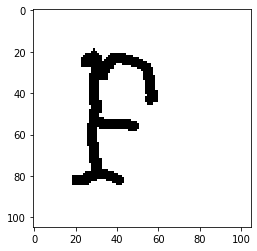

In [68]:
plot=556
for k,i in enumerate(data_loader):
#     print(i[0].shape,i[1].shape)
    if plot==k:
        print(which_cluster(i[1]))
        plt.imshow(i[0].squeeze().detach().cpu().numpy(),cmap='gray')
        break
#     print(type(i[0]),type(i[1]))
#     print(which_cluster(i[1]))
plt.show()

In [69]:
len(data_loader)

19280

In [70]:
# Lets build the CNN now.

In [ ]:
class OHCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1=nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=16)
        )